# Hire-Gutnisky-2015 - A DataJoint example
This notebook presents data and results associated with the following papers:
>Samuel Andrew Hires, Diego A Gutnisky, Jianing Yu, Daniel H O’Connor, and Karel Svoboda. "Low-noise encoding of active touch by
layer 4 in the somatosensory cortex" (2015) eLife (http://doi.org/10.7554/eLife.06619)

Original data shared here: http://crcns.org/data-sets/ssc/ssc-5/about-ssc-5

The data in original MATLAB format (.mat) have been ingested into a DataJoint data pipeline presented below. This notebook demonstrates the queries, processing, and reproduction of several figures from the paper. 
 

In [35]:
from datetime import datetime
import os
os.chdir('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import datajoint as dj
from pipeline import (reference, subject, acquisition, stimulation, analysis, virus,
                      intracellular, extracellular, behavior, utilities)

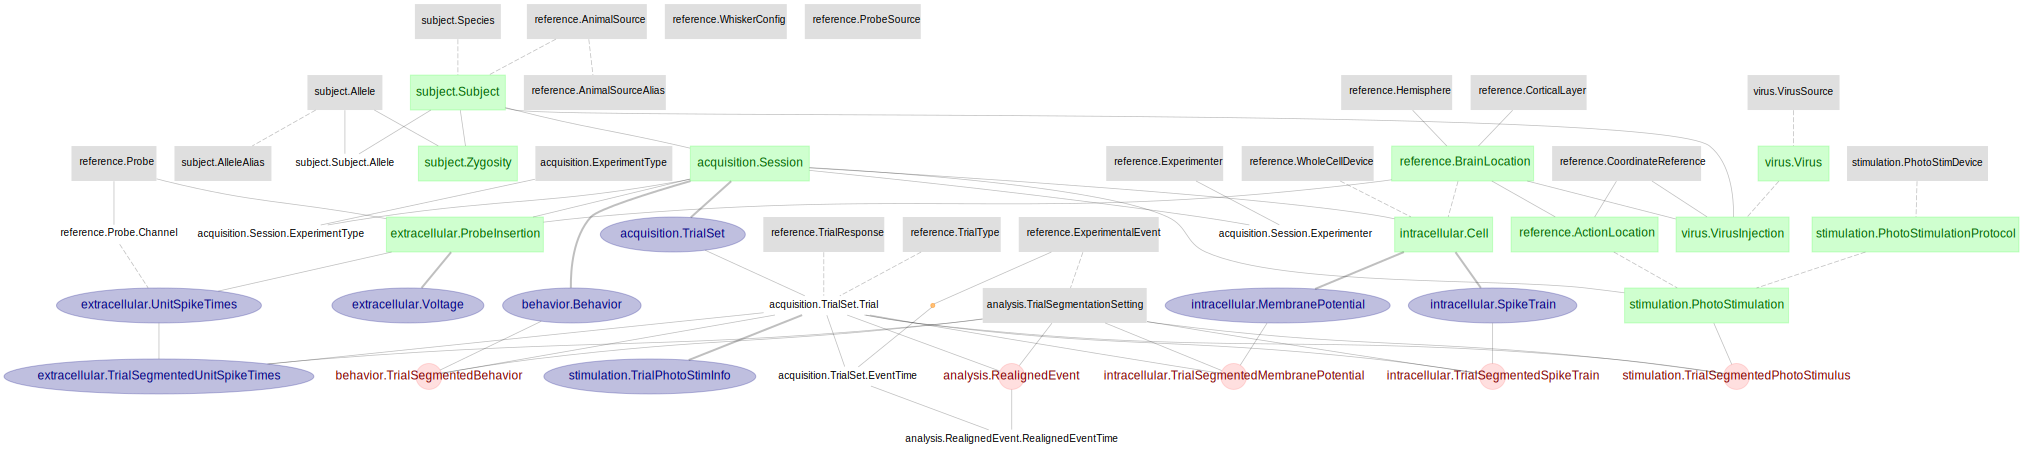

In [36]:
all_erd = (dj.ERD(reference) + dj.ERD(subject) + dj.ERD(virus)
           + dj.ERD(acquisition) + dj.ERD(analysis)
           + dj.ERD(stimulation) + dj.ERD(behavior)
           + dj.ERD(extracellular) + dj.ERD(intracellular))
dj.ERD(all_erd)

## Reproducing Figure 1B, C, E

### Select an example cell recording session - "Cell 23"

In [37]:
session_key = acquisition.Session & 'session_id="Cell23"'

In [38]:
trial_key = acquisition.TrialSet.Trial & session_key & 'trial_id=78'

In [39]:
# Specify segmentation setting to align to "trial_start" event
seg_param_key = (analysis.TrialSegmentationSetting & {'event': 'trial_start',
                                                      'pre_stim_duration': 0,
                                                      'post_stim_duration': 4}).fetch1()

### Figure 1A

In [40]:
# Get segmented Membrane Potential and Spike Train
mp = (intracellular.TrialSegmentedMembranePotential & trial_key & seg_param_key).fetch1('segmented_mp')
behav = (behavior.TrialSegmentedBehavior & trial_key & seg_param_key).fetch1()

In [41]:
# Get sampling rate
ephys_timestamps = np.linspace(-1*float(seg_param_key['pre_stim_duration']),
                               float(seg_param_key['post_stim_duration']),
                               mp.size)
behav_timestamps = np.linspace(-1*float(seg_param_key['pre_stim_duration']),
                               float(seg_param_key['post_stim_duration']),
                               behav['segmented_amplitude'].size)

In [42]:
print(mp[::10].shape)
print(behav['segmented_touch_onset'].shape)

(4000,)
(3990,)


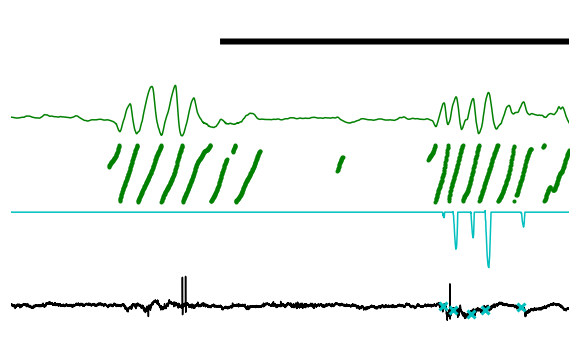

In [43]:
fig1a, axs = plt.subplots(5, 1, figsize=(10, 6))
fig1a.subplots_adjust(hspace=0.05)
axs[0].plot(behav_timestamps, np.where(behav['segmented_pole_available'] > 0, behav['segmented_pole_available'], np.nan), 'k',
           linewidth=6)
axs[1].plot(behav_timestamps, behav['segmented_theta_at_base'], 'g')
axs[2].plot(behav_timestamps, np.where(behav['segmented_amplitude'] > 2.5, behav['segmented_phase'], np.nan), '.g')
axs[3].plot(behav_timestamps, behav['segmented_delta_kappa'], 'c')
axs[4].plot(ephys_timestamps, mp, 'k')
axs[4].plot(behav_timestamps, np.where(behav['segmented_touch_onset'] == 1, mp[::10][:-10], np.nan), 'xc', 
            markeredgewidth=3, markersize=8)
for a in axs:
    a.set_xlim((0, 2))
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.spines['left'].set_visible(False)
    a.spines['bottom'].set_visible(False)
    a.set_xticks([])
    a.set_yticks([])

### Figure 1C, D

In [44]:
# get spike-train
spk = (intracellular.TrialSegmentedSpikeTrain & session_key & seg_param_key).fetch('segmented_spike_train')
ephys_timestamps = np.linspace(-1*float(seg_param_key['pre_stim_duration']),
                               float(seg_param_key['post_stim_duration']),
                               spk[0].size)

In [45]:
# restructure data for spike raster  
trial_idx, spike_times = zip(*((np.full_like(r, ri), r)
                                        for ri, r in enumerate(ephys_timestamps[np.where(r > 0)[0]] for r in spk)))
trial_idx = np.hstack(trial_idx)
spike_times = np.hstack(spike_times) 

In [46]:
# spike histogram
bin_size = 0.05  # (s)
spk_counts, spk_edges = np.histogram(np.hstack(ephys_timestamps[np.where(r > 0)[0]] for r in spk),
                                     bins=int((ephys_timestamps[-1] - ephys_timestamps[0]) / bin_size)
                                     , range=(ephys_timestamps[0], ephys_timestamps[-1]))
spk_rates = spk_counts / np.diff(spk_edges) / len(spk)

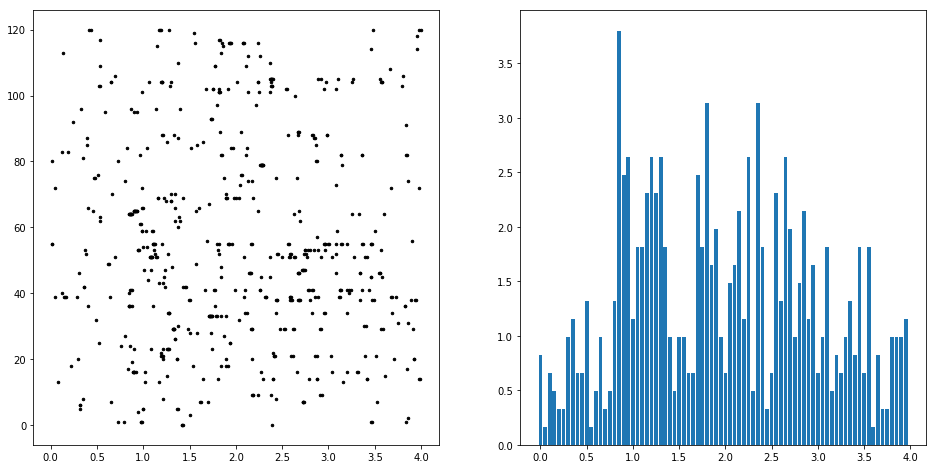

In [47]:
fig1cd, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(spike_times, trial_idx , '.k', markersize=5)
ax[1].bar(spk_edges[:-1], spk_rates, width=0.04);

### Figure 1E

In [48]:
np.warnings.filterwarnings('ignore')

In [49]:
# Specify segmentation setting to align to "first lick" event
seg_param_key = (analysis.TrialSegmentationSetting & {'event': 'first_lick',
                                                      'pre_stim_duration': 1,
                                                      'post_stim_duration': 4}).fetch1()

In [105]:
# get spike-train
spk = (intracellular.TrialSegmentedSpikeTrain & session_key & seg_param_key).fetch('segmented_spike_train')
touchon = (behavior.TrialSegmentedBehavior & session_key & seg_param_key).fetch('segmented_touch_onset')
ephys_timestamps = np.linspace(-1*float(seg_param_key['pre_stim_duration']),
                               float(seg_param_key['post_stim_duration']),
                               spk[0].size)

In [106]:
# get touch duration (last-touch - first-touch)
touch_dur = [np.diff(np.where(r > 0)[0][[0, -1]])[0] if np.where(r > 0)[0].size > 0 else -1 for r in touchon]

In [108]:
# sort trials based on touch duration
spk = spk[np.argsort(touch_dur)]

In [109]:
# restructure data for spike raster  
trial_idx, spike_times = zip(*((np.full_like(r, ri), r)
                                        for ri, r in enumerate(ephys_timestamps[np.where(r > 0)[0]] for r in spk)))
trial_idx = np.hstack(trial_idx)
spike_times = np.hstack(spike_times) 

In [112]:
# spike histogram
bin_size = 0.001  # (s)
spk_counts, spk_edges = np.histogram(np.hstack(ephys_timestamps[np.where(r > 0)[0]] for r in spk),
                                     bins= int((ephys_timestamps[-1] - ephys_timestamps[0]) / bin_size),
                                     range=(ephys_timestamps[0], ephys_timestamps[-1]))
spk_rates = spk_counts / np.diff(spk_edges) / len(spk)

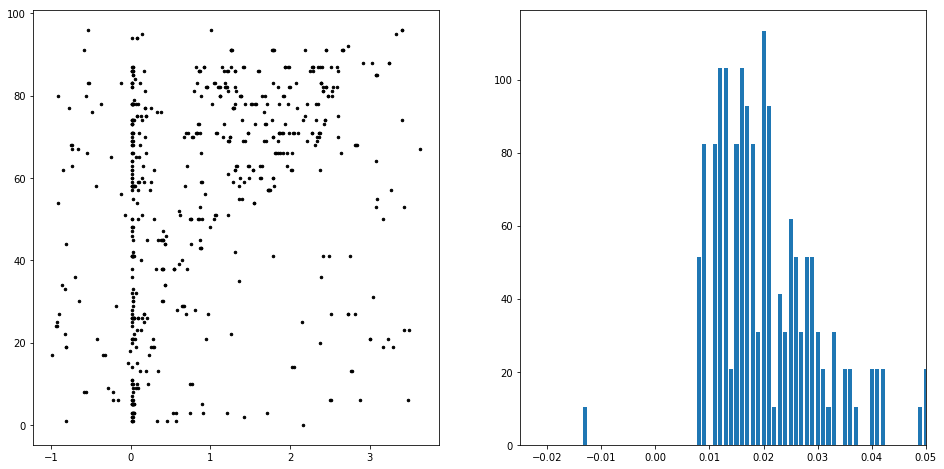

In [113]:
fig1ef, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(spike_times, trial_idx , '.k', markersize=5)
ax[1].bar(spk_edges[:-1], spk_rates, width=0.00075);
ax[1].set_xlim((-0.025, 0.05));

In [115]:
reference.BrainLocation()

brain_region,brain_subregion,cortical_layer layer within cortex,hemisphere,brain_location_full_name
barrel,C2,4,left,"S1, barrel field, Paxinos"
barrel,C2,5,left,"S1, barrel field, Paxinos"
barrel,C2,N/A,left,N/A
barrel,N/A,N/A,left,"S1, barrel field, Paxinos"
barrel,surround,4,left,"S1, barrel field, Paxinos"
